In [10]:
%pylab inline

Surface Stimuli
==========================

This tutorial covers the basics of defining and applying surface stimuli. 

NOTE: Surface simulations can also be run with stimuli defined at the region
level, in that case the stimuli take the same form as those discussed in 
"Tutorial: Region Stimuli".

Setup
-----

The setup and initialisation is done in the usual way, see "Anatomy of a Region Simulation" and
"Anatomy of a Surface Simulation" if you haven't already.

In [11]:
from tvb.simulator.lab import *

#Initialise a Model, Coupling, and Connectivity.
oscillator = models.Generic2dOscillator(d=0.1)
white_matter = connectivity.Connectivity(load_default=True)
white_matter.speed = 4.0

white_matter_coupling = coupling.Linear(a=-2**-9)

#Initialise an Integrator
heunint = integrators.HeunDeterministic(dt=2**-4)

#Initialise some Monitors with period in physical time
mon_tavg = monitors.TemporalAverage(period=2**-2)
mon_savg = monitors.SpatialAverage(period=2**-2)
# load the default region mapping
rm = region_mapping.RegionMapping(load_default=True)
mon_eeg = monitors.EEG(load_default=True, 
                       region_mapping=rm,
                       period=2**-2) 
#Bundle them
what_to_watch = (mon_tavg, mon_savg, mon_eeg)


A Surface with Custom LocalConnectivity
----------------------------------------

However, this time, instead of just using the default local connectivity we'll make a
custom one that has been chosen so that the influence of our stimuli will be more apparent.

In specifying the LocalConnectivity, we select from a set of equations defining functions
with finite support, that is they drop to zero as we move away from the origin. For practical
reasons (memory) we need to truncate the evaluation of the LocalConnectivity at some specified
distance, which we refer to as the "cutoff" distance.

NOTE: Distances are in mm, so the cutoff distance and standard deviation of the Gaussian 
below are 60mm and 10mm, respectively.

In [12]:
#Initialise a surface
local_coupling_strength = numpy.array([0.0121])

grey_matter = local_connectivity.LocalConnectivity(equation = equations.Gaussian(),
                                         cutoff = 60.0)
grey_matter.equation.parameters['sigma'] = 10.0
grey_matter.equation.parameters['amp'] = 1.0

default_cortex = cortex.Cortex(load_default=True)
default_cortex.local_connectivity = grey_matter
default_cortex.coupling_strength = local_coupling_strength

For a quick idea of how the LocalConnectivity we've just specified will be represented
on the surface we can use the plotting tool called plot_local_connectivity. This plots 
the local connectivity function with different sampling based on the distribution of 
edge lengths in your mesh surface. If all the lines don't, at least mostly, overlap
then you've probably specified a function with structure that is too fine for the 
resolution of your mesh surface. Also, you want the function to have essentially 
dropped to zero by the cutoff distance.  

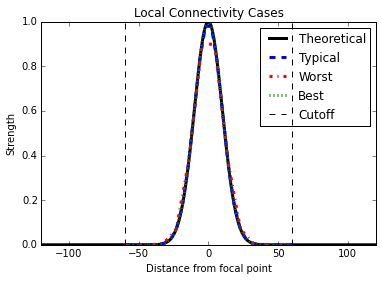

In [13]:
default_cortex.configure()
plot_local_connectivity(default_cortex)

Stimulus
---------

As with the region level stimuli, we use an equation to define the temporal profile,
however, unlike in the region level case, we also use an equation to define the spatial
profile of the stimulus. We also need to specify one or more "focal points" (vertices on
the cortical surface), about which the spatial equation will be evaluated. Here, as with
the LocalConnectivity, we must use an equation 
which drops toward zero with increasing distance. However, as we don't need to evaluate
the equation for every single vertex on the surface, but rather just for a typically 
small set of focal points, we don't need to truncate the evaluation with an explicit 
cutoff.

In [14]:
#Define the stimulus
eqn_t = equations.Gaussian()
eqn_t.parameters["amp"] = 1.0
eqn_t.parameters["midpoint"] = 8.0

eqn_x = equations.Gaussian()
eqn_x.parameters["amp"] =  -0.0625
eqn_x.parameters["sigma"] =  28.0

stimulus = patterns.StimuliSurface(surface = default_cortex,
                                   temporal = eqn_t, 
                                   spatial = eqn_x,
                                   focal_points_surface = numpy.array([8000]))

Simulate
---------

Now we bring all the pieces together into a Simulator object and configure it. We 
then run the simulator for a bit, throwing away the data, in order to clear the 
transient dynamics caused by imperfect initial conditions.

NOTE: The configure method for the Simulator must calculate the LocalConnectivity
here, which involves evaluating the LocalConnectivity function as a function of 
distance from every single vertex on the surface (about 16000 for the demo surface
we're using), so this step may take a minute or two. And then the transient clearing 
"dummy" simulation will take a few more...

In [15]:
#Initialise Simulator -- Model, Connectivity, Integrator, Monitors, and surface.
sim = simulator.Simulator(model = oscillator, 
                          connectivity = white_matter,
                          coupling = white_matter_coupling, 
                          integrator = heunint,  
                          monitors = what_to_watch, 
                          surface = default_cortex, 
                          stimulus = stimulus)

sim.configure()

#Clear the initial transient, so that the effect of the stimulus is clearer.
#NOTE: this is ignored, stimuli are defined relative to each simulation call.
LOG.info("Initial integration to clear transient...")
for _, _, _ in sim(simulation_length=128):
    pass

Then the main simulation loop

In [16]:
#Perform the simulation
tavg_data = []
tavg_time = []
savg_data = []
savg_time = []
eeg_data = []
eeg_time = []
for tavg, savg, eeg in sim(simulation_length=2**5):
    if not tavg is None:
        tavg_time.append(tavg[0])
        tavg_data.append(tavg[1])
    
    if not savg is None:
        savg_time.append(savg[0])
        savg_data.append(savg[1])
    
    if not eeg is None:
        eeg_time.append(eeg[0])
        eeg_data.append(eeg[1])

Plots
------

So, let's take a look at what we've done.

First, we can take a look at the stimuli we've applied to our simulation. We'll
use the same plot_pattern tool we used for region stimuli. This gives us a quick
overview, however, as you'll see, the representation of the space isn't all that useful.

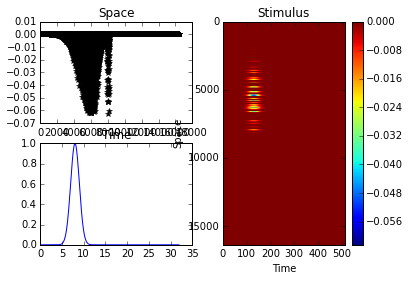

In [17]:
#Plot the stimulus
plot_pattern(sim.stimulus)

If we have Mayavi available, we can get a much better representation of the spatial
profile of the stimulus by plotting it directly onto our cortical surface, we'll do
this using the "surface_pattern" plotting tool.

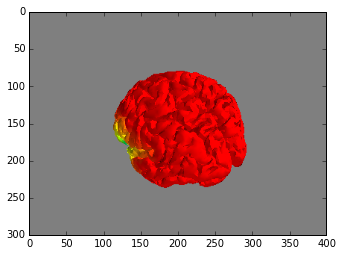

In [18]:
if IMPORTED_MAYAVI:
    from tvb.simulator.plot.tools import mlab
    surface_pattern(sim.surface, sim.stimulus.spatial_pattern)
    imshow(mlab.screenshot())

For the spatially down-sampled monitors, which in this example are SpatialAverage and EEG, we can plot the time-series in the usual way. 

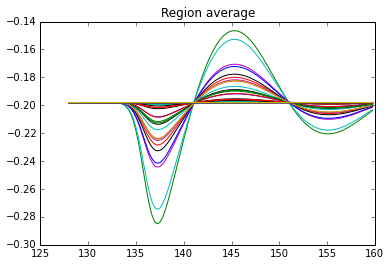

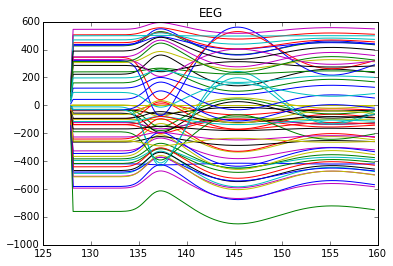

In [19]:
#Make the lists numpy.arrays for easier use.
TAVG = numpy.array(tavg_data)
SAVG = numpy.array(savg_data)
EEG = numpy.array(eeg_data)

#Plot region averaged time series
figure(3)
plot(savg_time, SAVG[:, 0, :, 0])
title("Region average")

#Plot EEG time series
figure(4)
plot(eeg_time, EEG[:, 0, :, 0])
title("EEG")

#Show them
show()

And finally, we can plot the full spatial resolution time-series as a movie on the 
cortical surface.

NOTE: it's also possible to plot the stimuli using the surface_timeseries plotting tool.

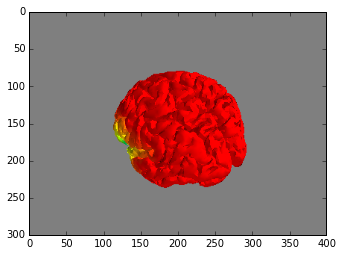

In [20]:
if IMPORTED_MAYAVI:
    from tvb.simulator.plot.tools import mlab
    st = surface_timeseries(sim.surface, TAVG[:, 0, :, 0])
    imshow(mlab.screenshot())
else:
    print "Sorry, you don't seem to have been able to import Mayavi."

That's All Folks, so, what now?
-------------------------------

...